In [50]:
import numpy as np
import pandas as pd
import geopandas as gpd
import osmnx as ox

### OSMnx

<AxesSubplot:>

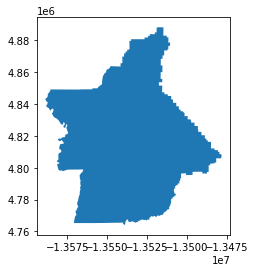

In [2]:
### get Butte county boundary
ca_counties = gpd.read_file('network_inputs/ca-county-boundaries/CA_Counties/CA_Counties_TIGER2016.shp')
butte = ca_counties[ca_counties['NAME']=='Butte']
butte.plot()

In [3]:
### Download and clean data using OSMnx: drive and service
# butte_g = ox.graph_from_polygon(butte.to_crs('epsg:4326')['geometry'].iloc[0], network_type='drive_service')

### Download and clean data using OSMnx: drive only
butte_g = ox.graph_from_polygon(butte.to_crs('epsg:4326')['geometry'].iloc[0], network_type='drive')
butte_g = ox.utils_graph.get_largest_component(butte_g, strongly=True)

In [4]:
### Nodes and Edges GDF
### Drive and service: (17220, 6) (41841, 17)
### Drive only: (13746, 6) (33077, 15)
butte_nodes, butte_edges = ox.graph_to_gdfs(butte_g)
print(butte_nodes.shape, butte_edges.shape)
butte_nodes.to_csv('network_inputs/butte_nodes_drive.csv', index=False)
butte_edges.to_csv('network_inputs/butte_edges_drive.csv', index=False)

(13738, 6) (33053, 15)


In [32]:
### add id to node
# butte_nodes = pd.read_csv('network_inputs/butte_nodes_drive.csv')
butte_nodes = pd.read_csv('network_inputs/butte_ctm_nodes.csv')
butte_nodes['nid'] = np.arange(butte_nodes.shape[0])
butte_nodes['lon'] = butte_nodes['x']
butte_nodes['lat'] = butte_nodes['y']
# butte_nodes[['nid', 'osmid', 'lon', 'lat']].to_csv('network_inputs/butte_nodes_sim.csv', index=False)
butte_nodes[['nid', 'osmid', 'lon', 'lat']].to_csv('network_inputs/butte_ctm_nodes_sim.csv', index=False)
### Further process
# butte_edges = pd.read_csv('network_inputs/butte_edges_drive.csv')
butte_edges = pd.read_csv('network_inputs/butte_ctm_edges_manual.csv')
butte_edges['geometry'] = butte_edges['WKT']
butte_edges.head()
butte_edges['type'] = butte_edges['highway']
butte_edges['type'] = np.where(butte_edges['highway']=="['residential', 'tertiary']", 'residential', butte_edges['type'])
butte_edges['type'] = np.where(butte_edges['highway']=="['trunk', 'motorway']", 'motorway', butte_edges['type'])
butte_edges['type'] = np.where(butte_edges['highway']=="['tertiary', 'unclassified']", 'unclassified', butte_edges['type'])
butte_edges['type'] = np.where(butte_edges['highway']=="['residential', 'unclassified']", 'unclassified', butte_edges['type'])
# butte_edges['type'].unique()
### max speed
butte_edges['maxmph'] = 25*0.8
butte_edges['maxmph'] = np.where(butte_edges['type'].isin(['motorway', 'motorway_link']), 55, butte_edges['maxmph'])
butte_edges['maxmph'] = np.where(butte_edges['type'].isin(['trunk', 'trunk_link']), 55, butte_edges['maxmph'])
butte_edges['maxmph'] = np.where(butte_edges['type'].isin(['primary', 'primary_link']), 55, butte_edges['maxmph'])
butte_edges['maxmph'] = np.where(butte_edges['type'].isin(['secondary', 'secondary_link']), 25, butte_edges['maxmph'])
butte_edges['maxmph'] = np.where(butte_edges['type'].isin(['tertiary', 'tertiary_link']), 25, butte_edges['maxmph'])
### lanes
butte_edges['lanes'] = 1
butte_edges['lanes'] = np.where(butte_edges['type'].isin(['motorway', 'motorway_link']), 2, butte_edges['lanes'])
butte_edges['lanes'] = np.where(butte_edges['type'].isin(['trunk', 'trunk_link']), 2, butte_edges['lanes'])
butte_edges['lanes'] = np.where(butte_edges['type'].isin(['primary', 'primary_link']), 2, butte_edges['lanes'])
butte_edges['lanes'] = np.where(butte_edges['type'].isin(['secondary', 'secondary_link']), 2, butte_edges['lanes'])
butte_edges['lanes'] = np.where(butte_edges['type'].isin(['tertiary', 'tertiary_link']), 2, butte_edges['lanes'])
### edge_id, start and end node
butte_edges['eid'] = np.arange(butte_edges.shape[0])
butte_edges = butte_edges.merge(butte_nodes[['nid', 'osmid']], how='left', left_on='u', right_on='osmid')
butte_edges = butte_edges.merge(butte_nodes[['nid', 'osmid']], how='left', left_on='v', right_on='osmid', suffixes=['_s', '_e'])
# butte_edges[['eid', 'nid_s', 'nid_e', 'length', 'maxmph', 'lanes', 'geometry']].to_csv(
#     'network_inputs/butte_edges_sim.csv', index=False)
butte_edges[['eid', 'nid_s', 'nid_e', 'length', 'maxmph', 'lanes', 'geometry']].to_csv(
    'network_inputs/butte_ctm_edges_sim.csv', index=False)

### CTM

In [59]:
from shapely.geometry import Point
from collections import Counter

### Load nodes and eges
butte_nodes = pd.read_csv('network_inputs/butte_nodes_drive.csv')
butte_nodes = gpd.GeoDataFrame(butte_nodes, crs='epsg:4326', geometry=[Point(xy) for xy in zip(butte_nodes.x, butte_nodes.y)])
butte_edges = pd.read_csv('network_inputs/butte_edges_drive.csv')

In [75]:
### Read city boundary
ca_cities = gpd.read_file('ca-places-boundaries/CA_Places_TIGER2016.shp')
paradise = ca_cities.loc[ca_cities['NAMELSAD']=='Paradise town', 'geometry'].to_crs('epsg:3857').buffer(300).to_crs('epsg:4326').iloc[0]

spatial_index = butte_nodes.sindex
possible_matches_index = list(spatial_index.intersection(paradise.bounds))
possible_matches = butte_nodes.iloc[possible_matches_index]
paradise_nodes = possible_matches[possible_matches.intersects(paradise)].reset_index(drop=True)
# paradise_nodes.to_csv('network_inputs/paradise_nodes.csv', index=False)
# display(paradise_nodes.head())

regional_route_files = ['skyway_nodes', 'neal_nodes', 'clark_nodes', 'pentz_nodes', 'CA70_nodes', 'CA70_oroville_nodes', 'CA149_nodes']
regional_nodes_list = []
for file in regional_route_files:
    regional_route_nodes = pd.read_csv('network_inputs/{}.csv'.format(file))
    regional_nodes_list.append(regional_route_nodes)
regional_nodes = pd.concat(regional_nodes_list)

potential_ctm_nodes = list(set(
    paradise_nodes['osmid'].values.tolist() + 
    regional_nodes['osmid'].values.tolist()))

### Remove small branch roads
undirected_nodes = pd.DataFrame(np.sort(butte_edges[['u', 'v']].values, axis=1), columns=[['u', 'v']]).drop_duplicates()
node_counts = Counter(undirected_nodes.values.flatten().tolist())
single_count_nodes = [n for n, v in node_counts.items() if v==1]
# print(len(node_counts), len(single_count_nodes))

# ### keep type
ctm_edges = butte_edges.copy().loc[
    ~(butte_edges['highway'].isin(['residential', 'living_street']) & (
        (butte_edges['u'].isin(single_count_nodes)) |
        (butte_edges['v'].isin(single_count_nodes)))
     ) & (
    butte_edges['u'].isin(potential_ctm_nodes)) & (
    butte_edges['v'].isin(potential_ctm_nodes))]
ctm_edges.to_csv('network_inputs/butte_ctm_edges.csv', index=False)
ctm_edges.shape

(2887, 15)

In [2]:
### Assign zones to CTM nodes
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.wkt import loads
from shapely.geometry import Point
import reduce_network_util

### extract CTM node from manually selected CTM edges
ctm_edges = pd.read_csv('network_inputs/butte_ctm_edges_manual.csv')
ctm_edges = ctm_edges.rename(columns={'WKT': 'geometry'})
ctm_nodes_list = np.unique(ctm_edges['u'].values.tolist() + ctm_edges['v'].values.tolist())
print(len(ctm_nodes_list), ctm_nodes_list[0:6])

### CTM nodes gdf
nodes = pd.read_csv('network_inputs/butte_nodes_drive.csv')
nodes = gpd.GeoDataFrame(nodes, geometry=[Point(xy) for xy in zip(nodes.x, nodes.y)], crs='epsg:4326').to_crs('epsg:3857')
ctm_nodes = nodes[nodes['osmid'].isin(ctm_nodes_list)].reset_index(drop=True)

### clean the network
# ctm_nodes.to_csv('network_inputs/butte_simplified_ctm_nodes_test.csv', index=False)
# ctm_edges.to_csv('network_inputs/butte_simplified_ctm_edges_test.csv', index=False)
# ctm_nodes = pd.read_csv('network_inputs/butte_simplified_ctm_nodes_test.csv')
# ctm_edges = pd.read_csv('network_inputs/butte_simplified_ctm_edges_test.csv')

nodes_no_stag, edges_no_stag = reduce_network_util.remove_stag_nodes(ctm_nodes, ctm_edges, iteration=20)
# nodes_no_stag.to_csv('network_inputs/butte_simplified_ctm_nodes_no_stag.csv', index=False)
# edges_no_stag.to_csv('network_inputs/butte_simplified_ctm_edges_no_stag.csv', index=False)
# nodes_no_stag = pd.read_csv('network_inputs/butte_simplified_ctm_nodes_test.csv')
# edges_no_stag = pd.read_csv('network_inputs/butte_simplified_ctm_edges_test.csv')
# print('********* ', edges_no_stag[edges_no_stag['osmid']=='538864403'].iloc[0])

nodes_remain, edges_remain = reduce_network_util.remove_false_intersections(nodes_no_stag, edges_no_stag)
# nodes_remain.to_csv('network_inputs/butte_simplified_ctm_nodes_no_false_int.csv', index=False)
# edges_remain.to_csv('network_inputs/butte_simplified_ctm_edges_no_false_int.csv', index=False)
# nodes_remain = pd.read_csv('network_inputs/butte_simplified_ctm_nodes_test.csv')
# edges_remain = pd.read_csv('network_inputs/butte_simplified_ctm_edges_test.csv')
# print('********* ', edges_remain[edges_remain['osmid']=='538864403'].iloc[0])

nodes_long, edges_long = reduce_network_util.short_elements_to_nodes(nodes_remain, edges_remain)
# # nodes_long.to_csv('network_inputs/butte_simplified_ctm_nodes_test.csv', index=False)
# # edges_long.to_csv('network_inputs/butte_simplified_ctm_edges_test.csv', index=False)
# # nodes_long = pd.read_csv('network_inputs/butte_simplified_ctm_nodes_test.csv')
# # edges_long = pd.read_csv('network_inputs/butte_simplified_ctm_edges_test.csv')

nodes_no_stag, edges_no_stag = reduce_network_util.remove_stag_nodes(nodes_long, edges_long)
# # nodes_no_stag.to_csv('network_inputs/butte_simplified_ctm_nodes_test.csv', index=False)
# # edges_no_stag.to_csv('network_inputs/butte_simplified_ctm_edges_test.csv', index=False)
# # nodes_no_stag = pd.read_csv('network_inputs/butte_simplified_ctm_nodes_test.csv')
# # edges_no_stag = pd.read_csv('network_inputs/butte_simplified_ctm_edges_test.csv')

nodes_remain, edges_remain = reduce_network_util.remove_false_intersections(nodes_no_stag, edges_no_stag)
# # nodes_remain.to_csv('network_inputs/butte_simplified_ctm_nodes_test.csv', index=False)
# # edges_remain.to_csv('network_inputs/butte_simplified_ctm_edges_test.csv', index=False)
# # nodes_remain = pd.read_csv('network_inputs/butte_simplified_ctm_nodes_test.csv')
# # edges_remain = pd.read_csv('network_inputs/butte_simplified_ctm_edges_test.csv')

### populate node attributes
nodes = nodes_remain[['x', 'y', 'osmid']].copy()
nodes['type'] = 'real'
nodes['node_id'] = np.arange(nodes.shape[0])
nodes = nodes.rename(columns={'x': 'lon', 'y': 'lat', 'osmid': 'node_osmid'})
display(nodes[['node_id', 'lon', 'lat', 'type', 'node_osmid']].head())
nodes[['node_id', 'lon', 'lat', 'type', 'node_osmid']].to_csv('network_inputs/butte_simplified_ctm_nodes.csv', index=False)

### populate edge attributes
edges = edges_remain[['u', 'v', 'highway', 'geometry']].copy()
edges['link_id'] = np.arange(edges.shape[0])
edges = edges.rename(columns={'u': 'start_osmid', 'v': 'end_osmid', 'highway': 'type'})
# edges['start_osmid'] = edges['start_osmid'].astype('str')
edges = edges.merge(nodes[['node_osmid', 'node_id']], how='left', left_on='start_osmid', right_on='node_osmid').merge(nodes[['node_osmid', 'node_id']], how='left', left_on='end_osmid', right_on='node_osmid', suffixes=['_start', '_end'])
edges = edges.rename(columns={'node_id_start': 'start_node_id', 'node_id_end': 'end_node_id'})
print(edges['type'].unique())

# ### max speed
edges['maxmph'] = 25*0.8
edges['maxmph'] = np.where(edges['type'].isin(['motorway', 'motorway_link']), 55, edges['maxmph'])
edges['maxmph'] = np.where(edges['type'].isin(['trunk', 'trunk_link']), 55, edges['maxmph'])
edges['maxmph'] = np.where(edges['type'].isin(['primary', 'primary_link']), 55, edges['maxmph'])
edges['maxmph'] = np.where(edges['type'].isin(['secondary', 'secondary_link']), 25, edges['maxmph'])
edges['maxmph'] = np.where(edges['type'].isin(['tertiary', 'tertiary_link']), 25, edges['maxmph'])

# ### lanes
edges['lanes'] = 1
edges['lanes'] = np.where(edges['type'].isin(['motorway', 'motorway_link']), 2, edges['lanes'])
edges['lanes'] = np.where(edges['type'].isin(['trunk', 'trunk_link']), 2, edges['lanes'])
edges['lanes'] = np.where(edges['type'].isin(['primary', 'primary_link']), 2, edges['lanes'])
edges['lanes'] = np.where(edges['type'].isin(['secondary', 'secondary_link']), 2, edges['lanes'])
edges['lanes'] = np.where(edges['type'].isin(['tertiary', 'tertiary_link']), 2, edges['lanes'])

# ### capacity
edges['capacity'] = edges['lanes']*1900
### fft
edges = gpd.GeoDataFrame(edges, crs='epsg:4326', geometry=edges['geometry'].apply(loads))
edges['length'] = edges['geometry'].to_crs('epsg:3857').length
edges['fft'] = edges['length']/edges['maxmph'] * 2.23694

edges = edges[['link_id', 'start_node_id', 'end_node_id', 'type', 'length', 'maxmph', 'lanes', 'capacity', 'fft', 'start_osmid', 'end_osmid', 'geometry']]
display(edges.head())
edges.to_csv('network_inputs/butte_simplified_ctm_edges.csv', index=False)

## read evacuation zone file
evac_zones = gpd.read_file('demand_inputs/digitized_evacuation_zone/digitized_evacuation_zone.shp').to_crs('epsg:3857')
nodes = gpd.GeoDataFrame(nodes, geometry=[Point(xy) for xy in zip(nodes.lon, nodes.lat)], crs='epsg:4326').to_crs('epsg:3857')
nodes_sindex = nodes.sindex
nodes['evac_zone'] = -1

for zone in evac_zones.itertuples():
    zone_id = getattr(zone, 'id')
    zone_geom = getattr(zone, 'geometry')
    coarse_node_ids = list(nodes_sindex.intersection(zone_geom.bounds))
    coarse_nodes = nodes.iloc[coarse_node_ids]
    precise_nodes = coarse_nodes[coarse_nodes.intersects(zone_geom)]
    nodes['evac_zone'] = np.where(nodes['node_osmid'].isin(
        precise_nodes['node_osmid']), zone_id, nodes['evac_zone'])

nodes.groupby('evac_zone').size().head()
nodes.to_crs('epsg:4326').to_csv('network_inputs/butte_simplified_ctm_nodes_zones.csv', index=False)

843 [86370139 86370172 86370395 86371548 86371598 86373016]
remove_loops() removes 0 edges
remove_multiedges() removes 0 edges
iteration  0
  # staggring nodes:  11
iteration  1
  # staggring nodes:  9
iteration  2
  # staggring nodes:  9
iteration  3
  # staggring nodes:  7
iteration  4
  # staggring nodes:  5
iteration  5
  # staggring nodes:  5
iteration  6
  # staggring nodes:  4
iteration  7
  # staggring nodes:  4
iteration  8
  # staggring nodes:  3
iteration  9
  # staggring nodes:  1
iteration  10
  # staggring nodes:  1
iteration  11
  # staggring nodes:  1
iteration  12
  # staggring nodes:  1
iteration  13
  # staggring nodes:  1
iteration  14
  # staggring nodes:  1
iteration  15
  # staggring nodes:  1
iteration  16
  # staggring nodes:  1
iteration  17
  # staggring nodes:  0
iteration  18
  # staggring nodes:  0
iteration  19
  # staggring nodes:  0
remove_loops() removes 0 edges
remove_multiedges() removes 0 edges
  # staggring nodes: 0, # non-intersection nodes 652
# 

,node_id,lon,lat,type,node_osmid
16,0,-121.589019,39.755914,real,86606471
17,1,-121.581956,39.777753,real,86508207
20,2,-121.600692,39.755920,real,86606520
22,3,-121.586547,39.777728,real,86508220
30,4,-121.600650,39.777651,real,86508288


[motorway, motorway_link, trunk, trunk_link, primary, secondary, tertiary, residential]
Categories (8, object): [motorway, motorway_link, trunk, trunk_link, primary, secondary, tertiary, residential]


,link_id,start_node_id,end_node_id,type,length,maxmph,lanes,capacity,fft,start_osmid,end_osmid,geometry
0,0,96,33,motorway,4223.551071,55.0,2,3800,171.778733,476139708_m,449397448,"LINESTRING (-121.66227 39.60135, -121.66067 39..."
1,1,16,96,motorway,4173.838601,55.0,2,3800,169.756846,86419072,476139708_m,"LINESTRING (-121.63011 39.58652, -121.63129 39..."
2,2,14,15,motorway,395.198724,55.0,2,3800,16.073379,476161268,476161271,"LINESTRING (-121.62049 39.59374, -121.62041 39..."
3,3,29,14,motorway,731.976221,55.0,2,3800,29.770671,476164501,476161268,"LINESTRING (-121.61961 39.58872, -121.61985 39..."
4,4,33,29,motorway_link,2000.966666,55.0,2,3800,81.382589,449397448,476164501,"LINESTRING (-121.62990 39.58611, -121.62783 39..."


/Users/bingyu/anaconda3/envs/geo/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [8]:
### Assign speed etc to CTM edges

### Demand

In [22]:
import random 
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist 

from shapely import wkt 
from shapely.geometry import Point

In [33]:
### node file
nodes_df = pd.read_csv('network_inputs/butte_ctm_nodes_sim.csv')
nodes_gdf = gpd.GeoDataFrame(nodes_df, geometry=[Point(xy) for xy in zip(nodes_df.lon, nodes_df.lat)], crs='epsg:4326').to_crs('epsg:3857')

### city boundary
cities = gpd.read_file('network_inputs/ca-places-boundaries/CA_Places_TIGER2016.shp').to_crs('epsg:3857')
### individual cities
paradise = cities[cities['NAMELSAD']=='Paradise town'].copy()
magalia = cities[cities['NAMELSAD']=='Magalia CDP'].copy()
chico = cities[cities['NAMELSAD']=='Chico city'].copy()
oroville = cities.loc[cities['NAME'].isin(['Palermo', 'Oroville East', 'South Oroville', 'Kelly Ridge', 'Oroville', 'Thermalito'])].copy()

### parcel file
parcels = gpd.read_file('demand_inputs/BCAG_GIS_Request/parcel/parcel.shp').to_crs('epsg:3857')

### evacuation zone
evac_zones = gpd.read_file('demand_inputs/digitized_evacuation_zone/digitized_evacuation_zone.shp').to_crs('epsg:3857')

In [34]:
evac_zones_test = evac_zones.loc[evac_zones['id']<=14].copy()
evac_zones_test.to_crs('epsg:3857')['geometry'].unary_union.area/1e6
# evac_zones

90.89957966542207

In [35]:
### Residential parcels in Paradise
### did not consider Magalia and needs to be changed in the future
### did not consider all land use types

### While the pre-fire population of Paradise was an estimated 26,800, according to the U.S. 2010 Census, a door-to-door survey conducted in April of this year revealed only 2,034 residents remain
### https://sf.curbed.com/2019/7/12/20692079/town-destroyed-by-pg-e-fire-loses-92-percent-of-its-population
paradise_parcels = parcels.loc[(parcels['JURISDICTI']=='Paradise') & (parcels['LANDUSE'].isin(['RZ', 'RV', 'RS']))].copy()
paradise_parcels.groupby('LANDUSE').size()

LANDUSE
RS    2655
RV     609
RZ    6811
dtype: int64

In [37]:
### Map residential parcels in Paradise to nodes
paradise_parcels['centroid'] = paradise_parcels.apply(lambda x: x['geometry'].centroid, axis=1)
paradise_parcels = paradise_parcels.set_geometry('centroid')
paradise_parcels['c_x'] = paradise_parcels['centroid'].x
paradise_parcels['c_y'] = paradise_parcels['centroid'].y
nodes_xy = np.array([nodes_gdf['geometry'].x.values, nodes_gdf['geometry'].y.values]).transpose()
nodes_osmid = nodes_gdf['osmid'].values

def get_closest_node(parcel_x, parcel_y):
    return nodes_osmid[cdist([(parcel_x, parcel_y)], nodes_xy, 'euclidean').argmin()]

paradise_parcels['closest_node'] = paradise_parcels.apply(lambda x: get_closest_node(x['c_x'], x['c_y']), axis=1)
nodes_evac_origins = paradise_parcels.groupby('closest_node').size().reset_index().rename(columns={'closest_node': 'node_id', 0: 'hh_cnts'})
print(nodes_evac_origins.shape)
nodes_evac_origins.head()

(700, 2)


,node_id,hh_cnts
0,86370139,6
1,86370172,11
2,86370395,26
3,86373016,14
4,86373049,9


In [38]:
### assign an evacuation zone to each evacuation origin
nodes_evac_origins_gdf = nodes_gdf.merge(nodes_evac_origins, how='right', right_on='node_id', left_on='osmid')
nodes_evac_origins_sindex = nodes_evac_origins_gdf.sindex
nodes_evac_origins_gdf['evac_zone'] = -1

for zone in evac_zones.itertuples():
    zone_id = getattr(zone, 'id')
    zone_geom = getattr(zone, 'geometry')
    coarse_node_ids = list(nodes_evac_origins_sindex.intersection(zone_geom.bounds))
    coarse_nodes = nodes_evac_origins_gdf.iloc[coarse_node_ids]
    precise_nodes = coarse_nodes[coarse_nodes.intersects(zone_geom)]
    nodes_evac_origins_gdf['evac_zone'] = np.where(nodes_evac_origins_gdf['osmid'].isin(
        precise_nodes['osmid']), zone_id, nodes_evac_origins_gdf['evac_zone'])
nodes_evac_origins_gdf.groupby('evac_zone').agg({'hh_cnts': np.sum}).head()

,hh_cnts
evac_zone,
-1,144
1,1178
2,1068
3,879
4,1016


In [49]:
### assume 100% of evacuee
evac_pct = 1
### assume 2 veh per household
vphh = 2

### make OD
od_list = []
for node in nodes_evac_origins_gdf[['osmid', 'hh_cnts', 'evac_zone']].copy().sample(frac=evac_pct).itertuples():
    for hh_id in range(getattr(node, 'hh_cnts')):
        for v_id in range(vphh):
            od_list.append([getattr(node, 'osmid'), getattr(node, 'evac_zone'), hh_id, v_id])
od = pd.DataFrame(od_list, columns=['origin_osmid', 'evac_zone', 'hh_id', 'v_id'])
### only look at the first 14 zones
od = od.loc[od['evac_zone']<=14]
od_hh = od.drop_duplicates(subset=['origin_osmid', 'evac_zone', 'hh_id']).copy().drop(columns='v_id').sample(frac=1)

### find osmids in Oroville or Chico
print(oroville['NAME'].values.tolist()) ### Should be 6
safe_area_dict = {'chico': chico.unary_union, 'oroville': oroville.unary_union}
safe_nodes = dict()
nodes_sindex = nodes_gdf.sindex
for nm, geom in safe_area_dict.items():
    coarse_node_ids = list(nodes_sindex.intersection(geom.bounds))
    coarse_nodes = nodes_gdf.iloc[coarse_node_ids]
    precise_nodes = coarse_nodes[coarse_nodes.intersects(geom)]
    safe_nodes[nm] = precise_nodes['osmid'].values.tolist()
    print(nm, len(precise_nodes))
    
### virtual end nodes for CTM
nodes_vdf = nodes_df.copy()
edges_vdf = pd.read_csv('network_inputs/butte_ctm_edges_sim.csv')
print(nodes_vdf.shape, edges_vdf.shape)

nodes_vdf_list = []
node_vnid = np.max(nodes_vdf['nid'])
edges_vdf_list = []
edge_veid = np.max(edges_vdf['eid'])
for nm in ['chico', 'oroville']:
    before_virtual_nodes = nodes_gdf[nodes_gdf['osmid'].isin(safe_nodes[nm])].copy()
    print(nm, before_virtual_nodes.shape)
    virtual_nodes_lon = np.mean(before_virtual_nodes['lon'])
    virtual_nodes_lat = np.mean(before_virtual_nodes['lat'])
    node_vnid += 1
    nodes_vdf_list.append([node_vnid, 'vsink_{}'.format(nm), 
                           virtual_nodes_lon, virtual_nodes_lat, 
                           'POINT ({} {})'.format(virtual_nodes_lon, virtual_nodes_lat)
                          ])
    for bvn in before_virtual_nodes.itertuples():
        edge_veid += 1
        edges_vdf_list.append([edge_veid, getattr(bvn, 'nid'), node_vnid, 10000, 10000, 100, 
                              'LINESTRING({} {}, {} {})'.format(
                                  getattr(bvn, 'geometry').coords[-1][0], 
                                  getattr(bvn, 'geometry').coords[-1][1], 
                                  virtual_nodes_lon, virtual_nodes_lat)
                              ])

nodes_vdf = pd.concat([nodes_vdf, pd.DataFrame(
    nodes_vdf_list, columns=['nid', 'osmid', 'lon', 'lat', 'geometry'])])
edges_vdf = pd.concat([edges_vdf, pd.DataFrame(
    edges_vdf_list, columns=['eid', 'nid_s', 'nid_e', 'length', 'maxmph', 'lanes', 'geometry'])])
print(nodes_vdf.shape, edges_vdf.shape)
nodes_vdf.to_csv('network_inputs/butte_ctm_nodes_sim_virtual.csv')
edges_vdf.to_csv('network_inputs/butte_ctm_edges_sim_virtual.csv')



### add destination
chico_ratio = 0.7

# d_list = random.choices(
#     safe_nodes['chico'], k=int(od_hh.shape[0]*chico_ratio)) + random.choices(
#     safe_nodes['oroville'], k=od_hh.shape[0]-int(od_hh.shape[0]*chico_ratio))
d_list = random.choices(['vsink_chico', 'vsink_oroville'], k=od_hh.shape[0], weights=[chico_ratio, 1-chico_ratio])

od_hh['destin_osmid'] = d_list
### add departure time
od_hh['dept_time_scen_1'] = 0
od_hh['dept_time_scen_2'] = np.where(
        od_hh['evac_zone'].isin([1,2,3]), 0, np.where(
            od_hh['evac_zone'].isin([4,5,6,7,8]), 157*60, np.where(
                od_hh['evac_zone'].isin([9,10,11,12,13,14]), (157+205)*60, 0)))
od_hh['dept_time_scen_3'] = random.choices(
    range(20*60, 1*3600), k=int(od_hh.shape[0]*0.05)) + random.choices(
    range(1*3600, 2*3600), k=int(od_hh.shape[0]*0.55)) + random.choices(
    range(2*3600, 3*3600), k=int(od_hh.shape[0]*0.35)) + random.choices(
    range(3*3600, 6*3600), k=od_hh.shape[0]-int(od_hh.shape[0]*0.05)-int(od_hh.shape[0]*0.55)-int(od_hh.shape[0]*0.35))
od = od.merge(od_hh, how='left', on=['origin_osmid', 'evac_zone', 'hh_id'])
print(od.shape)
display(od.head())

od[['origin_osmid', 'destin_osmid', 'evac_zone', 'hh_id', 'v_id', 'dept_time_scen_1', 'dept_time_scen_2', 'dept_time_scen_3']].to_csv('demand_inputs/ctm_od_virtual.csv', index=False)

['Oroville', 'Kelly Ridge', 'Oroville East', 'Palermo', 'South Oroville', 'Thermalito']
chico 19
oroville 4
(843, 5) (1753, 7)
chico (19, 5)
oroville (4, 5)
(845, 5) (1776, 7)
(20138, 8)


,origin_osmid,evac_zone,hh_id,v_id,destin_osmid,dept_time_scen_1,dept_time_scen_2,dept_time_scen_3
0,86550000,2,0,0,vsink_chico,0,0,1219
1,86550000,2,0,1,vsink_chico,0,0,1219
2,86550000,2,1,0,vsink_chico,0,0,10520
3,86550000,2,1,1,vsink_chico,0,0,10520
4,86550000,2,2,0,vsink_oroville,0,0,5443
